
Review: 







  
  
    I bought this as a more portable version of my other Anker power bank, which came in a beautiful little foamy case that keeps it safe wherever I bring it and fits snugly. This one comes along and it's much longer, slipping and sliding around in a loose, surprisingly cheap mesh bag. It's surprisingly more of a problem to bring around than its bigger counterpart because of this case.
  

Review: 







  
  
    I removed 1 star for what appeared to be a slightly used product. Seems like it was scraped somewhere. I was going on a long trip and I needed the charger, otherwise I would have started an exchange.I trust Anker products and their quality control is usually very good. The charger works very well, so no complaints there.
  

Review: 







  
  
    I smelt something funny in the other room. This was the only thing charging.  I went to unplug the usb cable and heard a sizzling as it singed my skin.  In hindsight I should have unplugged it from the wal

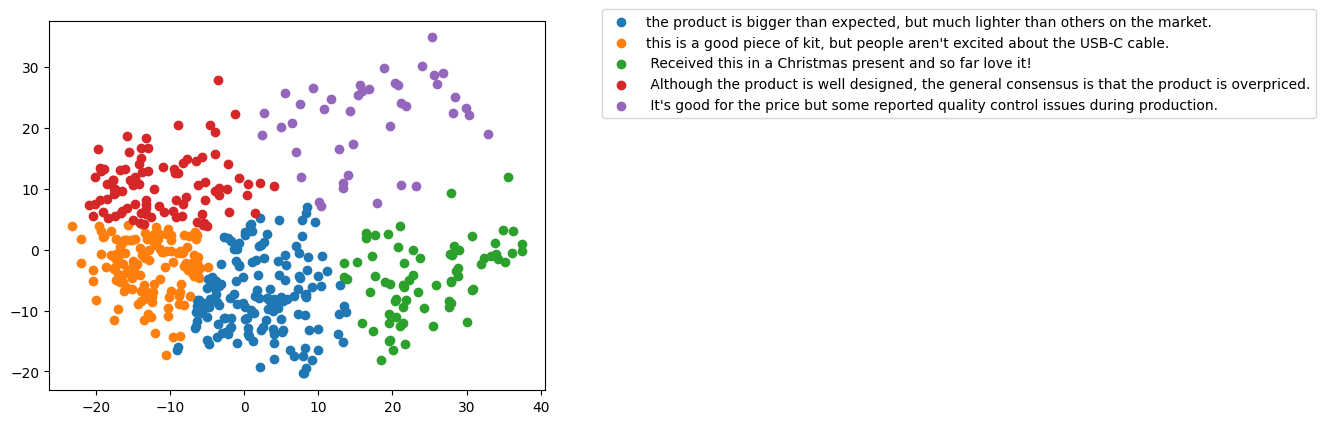

In [2]:
import cohere
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cohere.error import CohereError
import subprocess
from os.path import exists


def getReviews():
    if not exists("reviews.csv"):
        subprocess.run("scrapy runspider scraper.py -o reviews.csv",
                       shell=True)


def generateTldr(s_prompt):
    response = co.generate(
        model='large',
        prompt=
        'Review: You\'d think if you advertised a USB-C charged power bank that you could at least include a usb-c charging cable. included micro USB is just a cheap-out at this point. . capacity\'s fine, functionality is fine, build quality... feels a little less than i expected of Anker.\nReview: Went to charge it again and it wouldn’t charge. I attempted multiple outlets, charging wires, and chargers but it wouldn’t charge. Reached out to customer service and they claim that I am a week out of the warranty and they are unable to help me. I loved anker but I won’t be returning as a customer.\nReview: I got this charger for Christmas. It wasn\'t charging very fast (almost like a tickle charge). I did some research and I found using the USBC cable had it completely charged in a matter of hours. I get 8 charges on a full battery for my phone. A family member had her own pocket juice but kept \"\"stealing\"\" this one, as it charged her phone quickly and could get more uses out of the Anker. I purchased one for her as well and she loves it. The only draw back is it does not come with a usbc cable.\n\nTLDR: The general consensus is that that the device has charging issues.\n--\nReview: Very flimsy material and runs about 2 sizes SMALL.\nReview: It’s paper thin and zero cotton . Horrible material\nReview: Wasn’t sure how heavy the cloth would be, it turned out to be thinner and lighter but with enough body to be comfortable. Colors are good for a print.\n\nTLDR: The general consensus is the material is cheap, but the design printed well.\n--\n'
        + s_prompt,
        max_tokens=50,
        temperature=0.8,
        k=0,
        p=1,
        frequency_penalty=0,
        presence_penalty=0,
        stop_sequences=["--"],
        return_likelihoods='NONE')
    return response.generations[0].text


def structurePrompt(prompt_feed):
    to_return = "\n"
    for i in prompt_feed:
        to_return += "Review: " + str(i) + "\n"
    return to_return + "\nTLDR:"


class reviewNode:

    def __init__(self, text, coord):
        self.text = text
        self.coord = coord


if __name__ == "__main__":
    # scrape amazon reviews
    getReviews()
    numClusters = 5
    #Load Data
    reviews_df = pd.read_csv('reviews.csv', na_values=" NaN")
    review_list = list(reviews_df.dropna().comment)[0:500]
    data = pd.read_csv('reviews.csv')
    data = list(data)
    co = cohere.Client('QFBgGBv3qZJdCdYH5zVZvF0sbwC8Ma1r7xsWjZEJ')
    data = co.embed(model='cohere-toxicity', texts=review_list)
    data = np.array(data.embeddings)

    pca = PCA(2)

    #Transform the data
    df = pca.fit_transform(data)
    reviewNodes = []
    for i in range(0, len(df)):
        reviewNodes.append(reviewNode(review_list[i], df[i]))
    # for i in reviewNodes:
    #   print(i.text + " " + str(i.coord))

    #Initialize the class object
    kmeans = KMeans(n_clusters=numClusters)

    #predict the labels of clusters.
    label = kmeans.fit_predict(df)

    #Getting unique labels
    u_labels = np.unique(label)

    text_df = pd.DataFrame({"text": x.text} for x in reviewNodes)

    review_label_df = pd.DataFrame({
        "text": x.text,
        "coords": x.coord
    } for x in reviewNodes)

    all_label_coords = pd.DataFrame(columns=['coords', 'label'])

    for i in u_labels:
        coords = df[label == i]
        x = pd.DataFrame({"coords": x, "label": i} for x in coords)

        all_label_coords = pd.concat([all_label_coords, x])

    all_label_coords.coords = all_label_coords.coords.apply(tuple)
    review_label_df.coords = review_label_df.coords.apply(tuple)

    review_label_df = pd.merge(review_label_df,
                               all_label_coords,
                               on='coords',
                               how='outer')

    # print(review_label_df)

    # print([c for c in review_label_df['text']])
    labelInfo = dict()
    for i in u_labels:
        x = review_label_df.loc[review_label_df["label"] == i]
        prompt_feed = [c for c in x.text]
        pf_final = structurePrompt(prompt_feed)
        print(pf_final)

        try:
            tldr = generateTldr(pf_final)
        except CohereError:
            pf_final = structurePrompt(prompt_feed[::10])
            tldr = generateTldr(pf_final)

        print(str(i) + " " + str(tldr))

        labelInfo[i] = tldr[:-3].replace(" The general consensus is that ", "")

    print(labelInfo)

    for i in u_labels:
        plt.scatter(df[label == i, 0], df[label == i, 1], label=labelInfo[i])

    plt.legend(bbox_to_anchor=(1.1, 1.05))
    plt.show()
